In [ ]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install numpy==1.15.4 --user
!{sys.executable} -m pip install keras==2.1.3 --user
!{sys.executable} -m pip install pandas==0.23.4 --user
!{sys.executable} -m pip install scikit-image==0.14.1 --user
!{sys.executable} -m pip install scikit-learn==0.19.0 --user
!{sys.executable} -m pip install tensorflow --user
!{sys.executable} -m pip install imgaug --user



In [17]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import keras
import skimage
import tensorflow
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib
import skimage.morphology as morp
from skimage.filters import rank

%matplotlib inline

assert pd.__version__ == '0.23.4'
assert np.__version__ == '1.15.4'
assert keras.__version__ == '2.1.3'
assert skimage.__version__ == '0.14.1'
assert sklearn.__version__ == '0.19.2'
assert tensorflow.__version__ == '1.12.0'


In [2]:
train = pd.read_csv("../data/train.csv")
train_labels = train["Label"].values
train = train.sort_values("Img_Name").reset_index(drop=True)
train.head()

,Img_Name,Top,Left,Width,Height,Label
0,01-05 10.15.27_2.jpg,248,422,17,24,Speed Limit 60
1,01-05 10.15.38.jpg,360,765,45,60,Speed Limit 40
2,01-07 11.34.55.jpg,111,958,95,148,Speed Limit 20
3,01-07 16.39.19.jpg,282,1113,55,78,Speed Limit 40
4,01-09 01.46.39.jpg,357,872,30,31,Speed Limit 50


In [3]:
# Load all images. 

import os
import skimage.data
def load_data(data_dir):
    images = []
    
    file_names = sorted([os.path.join(data_dir, f)
                         for f in os.listdir(data_dir) if f.endswith(".jpg")])
    
    for f in file_names:
        images.append(skimage.data.imread(f)) #as_gray=True))

    return images

%time images = load_data('../data/object-detection-train')
print(len(images))

CPU times: user 21.5 s, sys: 1.92 s, total: 23.4 s
Wall time: 24.4 s
467


In [4]:
bb_orig = train[["Top", "Left", "Width", "Height"]].values
bb_orig.shape


(467, 4)

In [5]:
import imgaug as ia
from imgaug import augmenters as iaa

ia.seed(1)

image_size = (180,320)
def get_rescaled_img_and_bb(images, bb_orig, image_size=image_size):
    bbs = [ia.BoundingBoxesOnImage([
                ia.BoundingBox(
                    x1=bb_orig[i][0], 
                    x2=bb_orig[i][0] + bb_orig[i][3], 
                    y1=bb_orig[i][1], 
                    y2=bb_orig[i][1] + bb_orig[i][2]
                ),
            ], shape=images[i].shape)
           for i in range(len(images))]
    
    # Rescale image and bounding boxes
    images_rescaled = [ia.imresize_single_image(img, image_size) for img in images]
       
    bbs_rescaled = [bbs[i].on(images_rescaled[i]) for i in range(len(bbs))]
    bbs_rescaled_fixed = []
    for i in range(len(bbs_rescaled)):
        t = int(bbs_rescaled[i].bounding_boxes[0].x1)
        l = int(bbs_rescaled[i].bounding_boxes[0].y1)
        w = int(bbs_rescaled[i].bounding_boxes[0].y2 - bbs_rescaled[i].bounding_boxes[0].y1)
        h = int(bbs_rescaled[i].bounding_boxes[0].x2 - bbs_rescaled[i].bounding_boxes[0].x1)
        bbs_rescaled_fixed.append((t,l,w,h))

    return (images_rescaled, bbs_rescaled_fixed)

%time images_rescaled, bbs_rescaled = get_rescaled_img_and_bb(images, bb_orig)

CPU times: user 786 ms, sys: 1.31 s, total: 2.09 s
Wall time: 2.15 s


In [7]:
# Calculate Intersection-over-Union overlap between two bounding boxes
def IOU(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

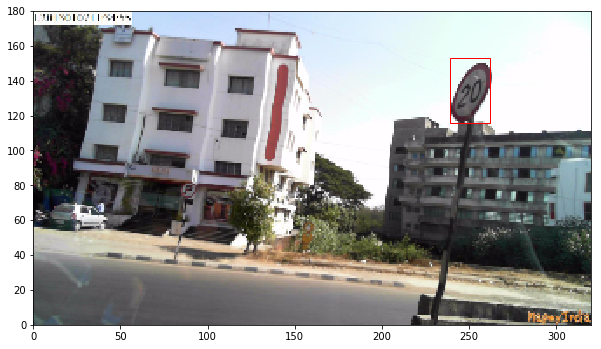

In [11]:
# Helper to visualize images with bounding boxes (and predicted bounding box)
def draw_img_bb(image, bb, bb_pred=None, image_size=None):
    if image_size:
        bb = bb*image_size
        if type(bb_pred) == np.ndarray:
            bb_pred = bb_pred*image_size
    plt.figure(figsize=(10, 10))
    plt.imshow((image).astype(np.uint8), cmap='Greys', interpolation='none', origin='upper', extent=[0, image.shape[1], 0, image.shape[0]])
    if type(bb_pred) == np.ndarray:
        plt.gca().add_patch(matplotlib.patches.Rectangle((bb_pred[1], image.shape[0]-bb_pred[0]-bb_pred[3]), bb_pred[2],bb_pred[3], ec='r', fc='none', linestyle='--'))
        plt.annotate('IOU: {:.2f}'.format(IOU(bb_pred, bb)), (bb_pred[1], image.shape[0]-bb_pred[0]+1), color='r')
    plt.gca().add_patch(matplotlib.patches.Rectangle((bb[1], image.shape[0]-bb[0]-bb[3]), bb[2],bb[3], ec='r', fc='none'))
    plt.show()
    
    
draw_img_bb(images_rescaled[2], bbs_rescaled[2])

In [12]:
# Rescale X and Y to 0-1 values
def norm_X(X):
    X_norm = X / 255.
    return X_norm

def denorm_X(X_norm):
    X_denorm = X_norm * 255.
    return X_denorm

def norm_y(y, image_size):
    y_norm = y / float(max(image_size))
    return y_norm

def denorm_y(y_norm, image_size):
    y_denorm = y_norm * max(image_size)
    return y_denorm

X = np.array(images_rescaled)
X = norm_X(X)
X.shape, np.mean(X), np.std(X)


((467, 180, 320, 3), 0.5350851647652084, 0.26952408145136586)

In [13]:
y = np.array(bbs_rescaled)
y = norm_y(y, image_size)
y.shape, np.mean(y), np.std(y)

((467, 4), 0.17097664614561026, 0.20106867941071663)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
from keras.constraints import maxnorm

total_epochs_trained = 0
epoch_acc = []

model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(image_size[0],image_size[1],3), 
                 activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(4, activation='sigmoid'))

from keras.optimizers import SGD
num_epochs = 100
lrate = 0.0002
decay = lrate/float(num_epochs)
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

model.compile(loss='mse', optimizer=sgd) #rmsprop

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 180, 320, 32)      2432      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 90, 160, 32)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 88, 158, 32)       9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 44, 79, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 42, 77, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 21, 38, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 25536)             0         
__________

In [31]:
# i=3
# draw_img_bb((X_train[i]*255).astype(np.uint8), y_train[i] * max(image_size))


In [ ]:
epochs_per_round = 1
print("IOU+MSE AFTER", total_epochs_trained, "EPOCHS:\n")

for i in range(20):
    model.fit(X_train, y_train, epochs=epochs_per_round, batch_size=32, verbose=1)
    total_epochs_trained += epochs_per_round

    pred = model.predict(X_test)
    IOUs = [IOU(pred[i],y_test[i]) for i in range(len(pred))]
    mean_IOU = np.mean(IOUs)

    print("EPOCH #", total_epochs_trained, "(mean IOU):", mean_IOU)

    if list(pred[0]) == list(pred[1]):
        print("Preds are the same...")
    
    epoch_acc.append((mean_IOU, total_epochs_trained))
    
    


IOU+MSE AFTER 0 EPOCHS:

Epoch 1/1
373/373 [==============================] - 33s 90ms/step - loss: 0.1492
EPOCH # 1 (mean IOU): 0.0
Epoch 1/1
373/373 [==============================] - 31s 82ms/step - loss: 0.1450
EPOCH # 2 (mean IOU): 0.0
Epoch 1/1
373/373 [==============================] - 30s 80ms/step - loss: 0.1396
EPOCH # 3 (mean IOU): 0.0
Epoch 1/1
373/373 [==============================] - 30s 82ms/step - loss: 0.1342
EPOCH # 4 (mean IOU): 0.0
Epoch 1/1
373/373 [==============================] - 31s 82ms/step - loss: 0.1281
EPOCH # 5 (mean IOU): 0.0
Epoch 1/1
373/373 [==============================] - 30s 81ms/step - loss: 0.1209
EPOCH # 6 (mean IOU): 0.0
Epoch 1/1
373/373 [==============================] - 43s 116ms/step - loss: 0.1131
EPOCH # 7 (mean IOU): 0.0
Epoch 1/1
373/373 [==============================] - 44s 119ms/step - loss: 0.1050
EPOCH # 8 (mean IOU): 0.0
Epoch 1/1
373/373 [==============================] - 49s 130ms/step - loss: 0.0964
EPOCH # 9 (mean IOU): 0.0


In [ ]:
pred_denorm = denorm_y(pred,image_size)
X_test_denorm = denorm_X(X_test)
y_test_denorm = denorm_y(y_test,image_size)

pred_denorm[:10]

In [ ]:
i = 10
draw_img_bb(X_test_denorm[i], y_test_denorm[i], pred_denorm[i])
